# Generating new images with DCGAN

In this example, we'll use TensorFlow 2.0 / Keras to implement DCGAN for generating new MNIST images.

_The code is based on_ [https://github.com/eriklindernoren/Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)<br />
_Author of the base implemenation: Erik Linder-Norén_ <br />
_License: MIT_

Let's start with the imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import \
    Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

We'll continue with the definition of the generator:

In [2]:
def build_generator(latent_input: Input):
    """
    :param latent_input: the latent input
    """

    model = Sequential([
        # start with a fully connected layer to upsample the 1d latent vector
        # the input_shape is the same as latent_input (excluding the mini-batch)
        Dense(7 * 7 * 256, use_bias=False, input_shape=latent_input.shape[1:]),
        BatchNormalization(), LeakyReLU(),

        # reshape the noise to feed to the transposed convolutions
        Reshape((7, 7, 256)),

        # expand the input with transposed convolutions
        Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(1, 1),
                        padding='same', use_bias=False),
        BatchNormalization(), LeakyReLU(),

        # gradually reduce the volume depth
        Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2),
                        padding='same', use_bias=False),
        BatchNormalization(), LeakyReLU(),

        # final transposed convolution with tanh activation
        # the generated image has only one channel
        Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2),
                        padding='same', use_bias=False, activation='tanh'),
    ])

    model.summary()

    # this is forward phase
    generated = model(latent_input)

    # build model from the input and output
    return Model(z, model(latent_input))

Next, we'll define the disciriminator:

In [3]:
def build_discriminator():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2),
               padding='same', input_shape=(28, 28, 1)),
        LeakyReLU(), Dropout(0.3),
        Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2),
               padding='same'),
        LeakyReLU(), Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid'),
    ])

    model.summary()

    image = Input(shape=(28, 28, 1))
    output = model(image)

    return Model(image, output)

Let's continue with the training process. It alternates between training the discriminator with sets of real and fake images, and training the generator (using the combined discriminator/generator model):

In [4]:
def train(generator, discriminator, combined, steps, batch_size):
    """
    Train the GAN system
    :param generator: generator
    :param discriminator: discriminator
    :param combined: stacked generator and discriminator
    we'll use the combined network when we train the generator
    :param steps: number of alternating steps for training
    :param batch_size: size of the minibatch
    """

    # Load the dataset
    (x_train, _), _ = mnist.load_data()

    # Rescale in [-1, 1] interval
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)

    # Discriminator ground truths
    real, fake = np.ones((batch_size, 1)), np.zeros((batch_size, 1))

    latent_dim = generator.input_shape[1]

    for step in range(steps):
        # Train the discriminator

        # Select a random batch of images
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]

        # Random batch of noise
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        generated_images = generator.predict(noise)

        # Train the discriminator
        discriminator_real_loss = discriminator.train_on_batch(real_images, real)
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake)
        discriminator_loss = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)

        # Train the generator
        # random latent vector z
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator
        # Note that we use the "valid" labels for the generated images
        # That's because we try to maximize the discriminator loss
        generator_loss = combined.train_on_batch(noise, real)

        # Display progress
        if step % 1000 == 0:
            print("%d [Discriminator loss: %.4f%%, acc.: %.2f%%] [Generator loss: %.4f%%]" %
                  (step, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))

Next, we'll define the `plot_generated_images` function, which generates a grid of newly generated MNIST images:

In [5]:
def plot_generated_images(generator):
    """
    Display a nxn 2D manifold of digits
    :param generator: the generator
    """
    n = 10
    digit_size = 28

    # big array containing all images
    figure = np.zeros((digit_size * n, digit_size * n))

    latent_dim = generator.input_shape[1]

    # n*n random latent distributions
    noise = np.random.normal(0, 1, (n * n, latent_dim))

    # generate the images
    generated_images = generator.predict(noise)

    # fill the big array with images
    for i in range(n):
        for j in range(n):
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28, 28))

    # plot the results
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Finally, let's put it all together. We'll start by instantiating the `generator`, the `discrimantor`, the `combined` model, and the training framework. Then, we'll initiate the training for 50,000 episodes. Finally, we'll plot a few images to see the results of the training:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             802816    
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

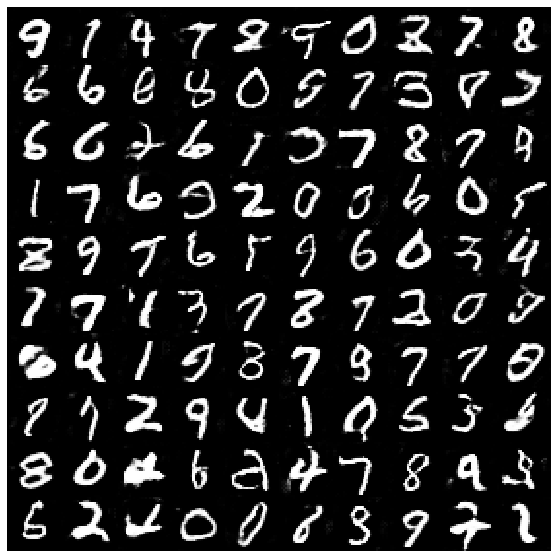

In [6]:
latent_dim = 64

# Build the generator
# Generator input z
z = Input(shape=(latent_dim,))

generator = build_generator(z)

generated_image = generator(z)

# we'll use Adam optimizer
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Only train the generator for the combined model
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
real_or_fake = discriminator(generated_image)

# Stack the generator and discriminator in a combined model
# Trains the generator to deceive the discriminator
combined = Model(z, real_or_fake)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# train the GAN system
train(generator, discriminator, combined, steps=50000, batch_size=100)

# display some random generated images
plot_generated_images(generator)
